In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


/home/idies/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
model_name = "hugohrban/progen2-small"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).eval().cuda()

In [12]:
def compute_log_likelihood(sequence, model, tokenizer):
    """Compute log-likelihood of a given sequence using ProGen2."""
    inputs = tokenizer(sequence, return_tensors="pt", padding=False, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU if available
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return -outputs.loss.item()  # Negative loss is log-likelihood



In [13]:
import pandas as pd

# Load a benchmark dataset
benchmark_file = "OBSCN_HUMAN_Tsuboyama_2023_1V1C.csv"  
df = pd.read_csv(benchmark_file)

# Preview dataset
df.head()


,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A15C,FDIYVVTADYLPLGCEQDAITLREGQYVEVLDAAHPLRWLVRTKPT...,0.211419,1
1,A15D,FDIYVVTADYLPLGDEQDAITLREGQYVEVLDAAHPLRWLVRTKPT...,0.635936,1
2,A15E,FDIYVVTADYLPLGEEQDAITLREGQYVEVLDAAHPLRWLVRTKPT...,0.277172,1
3,A15F,FDIYVVTADYLPLGFEQDAITLREGQYVEVLDAAHPLRWLVRTKPT...,0.099342,1
4,A15G,FDIYVVTADYLPLGGEQDAITLREGQYVEVLDAAHPLRWLVRTKPT...,0.309341,1


In [14]:
ref_seq = "FDIYVVTADYLPLGAEQDAITLREGQYVEVLDAAHPLRWLVRTKPTKSSPSRQGWVSPAYLDRRL"

In [15]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    wildtype = ref_seq
    mutant = row["mutated_sequence"]

    log_likelihood_wildtype = torch.tensor(compute_log_likelihood(wildtype, model, tokenizer), device=device)
    log_likelihood_mutant = torch.tensor(compute_log_likelihood(mutant, model, tokenizer), device=device)

    llr_score = log_likelihood_mutant - log_likelihood_wildtype  # Compute LLR

    results.append({"Mutation": row["mutant"], "LLR": llr_score.item()})  # Convert tensor to float

# Convert results to DataFrame
results_df = pd.DataFrame(results)


100%|██████████| 3197/3197 [01:57<00:00, 27.15it/s]


In [18]:
results_df
results_df.to_csv("progen2_proteingym_results.csv", index=False)

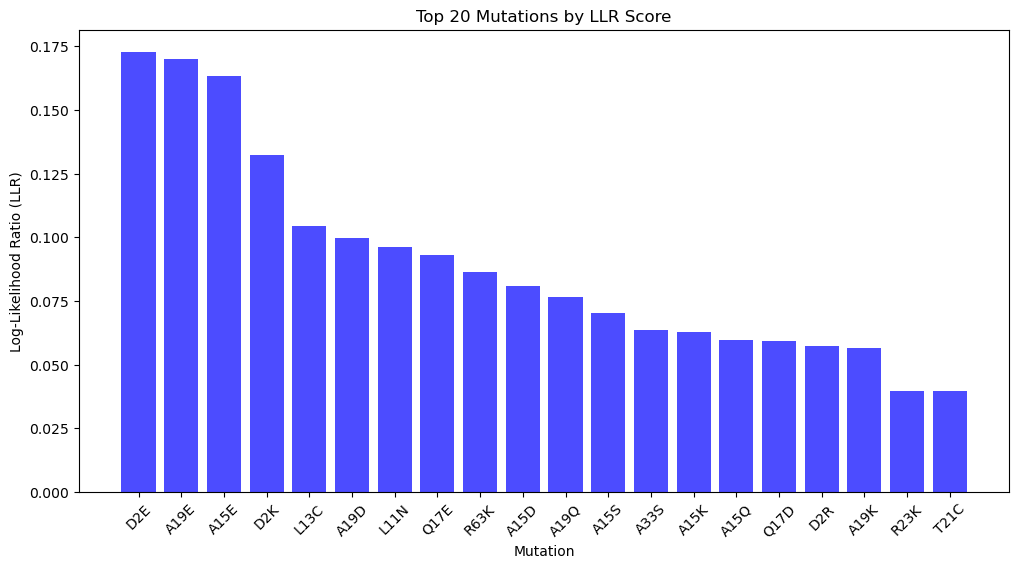

In [17]:

# Sort results for better visualization
results_df = results_df.sort_values(by="LLR", ascending=False)

# Plot LLR Scores
plt.figure(figsize=(12, 6))
plt.bar(results_df["Mutation"][:20], results_df["LLR"][:20], color="blue", alpha=0.7)
plt.xlabel("Mutation")
plt.ylabel("Log-Likelihood Ratio (LLR)")
plt.title("Top 20 Mutations by LLR Score")
plt.xticks(rotation=45)
plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/OATML/ProteinGym.git to /tmp/pip-req-build-vey6n9cp
  Running command git clone --filter=blob:none --quiet https://github.com/OATML/ProteinGym.git /tmp/pip-req-build-vey6n9cp
Username for 'https://github.com': ^C
ERROR: Operation cancelled by user


In [ ]:
!python evaluate_predictions.py --predictions progen2_proteingym_results.csv --dataset data/fitness_datasets/DMS_SARS2_RBD.csv


In [22]:
print(torch.cuda.is_available())

True
